In [4]:
from IPython.display import display
import IPython
import pandas as pd
from pandas import Series
import numpy as np
from random import randrange

from matplotlib import pyplot
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

# np.float_ = np.float64
# from prophet import Prophet
import sys
sys.path.append('..')


import math
from typing import Any, List, Dict, AnyStr, Optional
from pathlib import Path
from glob import glob

from utils.dataset import MarketData, DataPreprocessor, Plotting
from utils.windowgenerator import WindowGenerator, compile_and_fit

import tensorflow as tf
import talib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from matplotlib.backends.backend_agg import RendererAgg


In [6]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('../data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
# auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()


Ice Columns : Index(['Date', 'High', 'Open', 'Low', 'Close'], dtype='object')
           Date   High   Open    Low  Close
1    2025-01-13   0.00      0   0.00   0.00
2    2025-01-10  75.18  73.39  72.33  74.79
3    2025-01-09  73.71  71.95  71.55  73.48
4    2025-01-08  74.62  74.62  71.91  72.34
5    2025-01-07  74.92  74.56  72.91  74.18
...         ...    ...    ...    ...    ...
1040 2021-01-19  33.12  31.71  31.71  33.09
1041 2021-01-18  32.32  31.62  31.29  31.62
1042 2021-01-15  33.49  33.49  31.62  31.74
1043 2021-01-14  33.92  33.49  32.76  33.53
1044 2021-01-13  34.66  34.57  33.07  33.65

[1044 rows x 5 columns]


/Users/zeerakwyne/Documents/freelance/carbon-market-forecasting/notebooks/../utils/dataset.py:203: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  # First convert any string values to numeric, handling spaces
/Users/zeerakwyne/Documents/freelance/carbon-market-forecasting/notebooks/../utils/dataset.py:203: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  # First convert any string values to numeric, handling spaces
/Users/zeerakwyne/Documents/freelance/carbon-market-forecasting/notebooks/../utils/dataset.py:203: FutureWarning: Downcast

In [14]:
auction_df[auction_df['Auc Price'] < 0]

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
2128,2024-04-01,-0.05724,0.0,1.720,0.0,-0.05724,0.0,-inf
2396,2024-12-25,-0.05724,0.0,1.675,0.0,-0.05724,0.0,-inf
2397,2024-12-26,-0.05724,0.0,1.680,0.0,-0.05724,0.0,-inf
2413,2025-01-13,-0.05724,0.0,1.695,0.0,-0.05724,0.0,-inf


In [4]:
auction_df

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
0,2018-06-04,15.28,15.23,1.98,15.28,0.00,-0.05,NaN
1,2018-06-05,16.35,16.33,2.28,16.42,-0.07,-0.09,NaN
2,2018-06-06,15.70,15.68,2.31,15.81,-0.11,-0.13,NaN
3,2018-06-07,16.14,15.99,2.32,16.04,0.10,-0.05,NaN
4,2018-06-08,15.78,15.80,1.77,15.87,-0.09,-0.07,NaN
...,...,...,...,...,...,...,...,...
2408,2025-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2409,2025-01-07,71.02,71.06,1.37,71.22,-0.20,-0.16,-0.002808
2410,2025-01-08,71.50,71.08,2.27,71.23,0.27,-0.15,0.003791
2411,2025-01-09,70.01,69.91,1.57,70.07,-0.06,-0.16,-0.000856


In [4]:
def analyze_price_relationships(df):
    # Calculate average differences and ratios
    df['Spot_Close_Diff'] = df['Spot Value'] - df['Close']
    df['Spot_Close_Ratio'] = df['Spot Value'] / df['Close']
    df['Auc_Spot_Diff'] = df['Auc Price'] - df['Spot Value']
    df['Auc_Spot_Ratio'] = df['Auc Price'] / df['Spot Value']
    
    # Calculate statistics for non-null pairs
    stats = {
        'Spot_Close_Diff_Mean': df['Spot_Close_Diff'].mean(),
        'Spot_Close_Diff_Median': df['Spot_Close_Diff'].median(),
        'Spot_Close_Ratio_Mean': df['Spot_Close_Ratio'].mean(),
        'Auc_Spot_Diff_Mean': df['Auc_Spot_Diff'].mean(),
        'Auc_Spot_Diff_Median': df['Auc_Spot_Diff'].median(),
        'Auc_Spot_Ratio_Mean': df['Auc_Spot_Ratio'].mean(),
    }
    
    return stats

def fill_missing_values(df):
    # First, get the historical relationships
    stats = analyze_price_relationships(df)
    
    # Create a copy to avoid modifying the original
    filled_df = df.copy()
    
    # 1. Fill Spot Value first (using Close price)
    mask = filled_df['Spot Value'].isna() & filled_df['Close'].notna()
    filled_df.loc[mask, 'Spot Value'] = (
        filled_df.loc[mask, 'Close'] * stats['Spot_Close_Ratio_Mean']
    )
    
    # 2. Fill Auc Price (using newly filled Spot Value)
    mask = filled_df['Auc Price'].isna() & filled_df['Spot Value'].notna()
    filled_df.loc[mask, 'Auc Price'] = (
        filled_df.loc[mask, 'Spot Value'] + stats['Auc_Spot_Diff_Mean']
    )
    
    # 3. Fill Median Price (as average of High and Low of the day)
    mask = filled_df['Median Price'].isna()
    filled_df.loc[mask, 'Median Price'] = (
        (filled_df.loc[mask, 'High'] + filled_df.loc[mask, 'Low']) / 2
    )

    filled_df['Median Spot Diff'] = filled_df['Median Price'] - filled_df['Spot Value']
    filled_df['Auction Spot Diff'] = filled_df['Auc Price'] - filled_df['Spot Value'] 
    filled_df['Premium/discount-settle'] =  filled_df['Auction Spot Diff'] / filled_df['Spot Value']
    # 4. Fill Cover Ratio with rolling median
    filled_df['Cover Ratio'] = filled_df['Cover Ratio'].fillna(
        filled_df['Cover Ratio'].rolling(window=30, min_periods=1).median()
    )
    
    return filled_df

# Function to validate the filling
def validate_filling(original_df, filled_df):
    # Calculate percentage of filled values
    total_rows = len(original_df)
    
    for col in ['Spot Value', 'Auc Price', 'Median Price', 'Cover Ratio']:
        original_nulls = original_df[col].isna().sum()
        filled_nulls = filled_df[col].isna().sum()
        filled_count = original_nulls - filled_nulls
        
        print(f"\n{col}:")
        print(f"Originally missing: {original_nulls} ({original_nulls/total_rows*100:.2f}%)")
        print(f"Filled: {filled_count} ({filled_count/total_rows*100:.2f}%)")
        print(f"Still missing: {filled_nulls} ({filled_nulls/total_rows*100:.2f}%)")

ice_df = pd.read_excel('../data/data_sheet_latest.xlsx', sheet_name='ICE Value', skiprows=4)
ice_df = ice_df[['Unnamed: 11', 'High', 'Open', 'Low', 'Close']][1:]
ice_df.columns = ['Date', 'High', 'Open', 'Low', 'Close']

ice_df['Date'] = pd.to_datetime(ice_df['Date'])
ice_df = ice_df[ice_df['Date'].dt.year >= 2000]
ice_df['Date'] = ice_df['Date'].dt.date
ice_df['Date'] = pd.to_datetime(ice_df['Date'])
ice_df = ice_df[1:]

merged_df = pd.merge(auction_df, ice_df, on='Date', how='outer')
filled_df = fill_missing_values(merged_df)
filled_df = filled_df[auction_df.columns]

NameError: name 'auction_df' is not defined

In [6]:
ice_df.columns

Index(['Date', 'High', 'Open', 'Low', 'Close'], dtype='object')

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
0,2018-06-04,15.280000,15.230,1.98,15.280000,0.00000,-0.050000,0.000000
1,2018-06-05,16.350000,16.330,2.28,16.420000,-0.07000,-0.090000,-0.004263
2,2018-06-06,15.700000,15.680,2.31,15.810000,-0.11000,-0.130000,-0.006958
3,2018-06-07,16.140000,15.990,2.32,16.040000,0.10000,-0.050000,0.006234
4,2018-06-08,15.780000,15.800,1.77,15.870000,-0.09000,-0.070000,-0.005671
...,...,...,...,...,...,...,...,...
2408,2025-01-06,73.306663,74.975,1.65,73.363903,-0.05724,1.611097,-0.000780
2409,2025-01-07,71.020000,71.060,1.37,71.220000,-0.20000,-0.160000,-0.002808
2410,2025-01-08,71.500000,71.080,2.27,71.230000,0.27000,-0.150000,0.003791
2411,2025-01-09,70.010000,69.910,1.57,70.070000,-0.06000,-0.160000,-0.000856


In [189]:

merged_df

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,High,Open,Low,Close
0,2018-06-04,15.28,15.23,1.98,15.28,0.00,-0.05,NaN,NaN,NaN,NaN,NaN
1,2018-06-05,16.35,16.33,2.28,16.42,-0.07,-0.09,NaN,NaN,NaN,NaN,NaN
2,2018-06-06,15.70,15.68,2.31,15.81,-0.11,-0.13,NaN,NaN,NaN,NaN,NaN
3,2018-06-07,16.14,15.99,2.32,16.04,0.10,-0.05,NaN,NaN,NaN,NaN,NaN
4,2018-06-08,15.78,15.80,1.77,15.87,-0.09,-0.07,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2408,2025-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.15,75.94,73.80,74.32
2409,2025-01-07,71.02,71.06,1.37,71.22,-0.20,-0.16,-0.002808,74.92,74.56,72.91,74.18
2410,2025-01-08,71.50,71.08,2.27,71.23,0.27,-0.15,0.003791,74.62,74.62,71.91,72.34
2411,2025-01-09,70.01,69.91,1.57,70.07,-0.06,-0.16,-0.000856,73.71,71.95,71.55,73.48


In [73]:
processing_df = processing_df[processing_df['Date'].dt.year >= 2024]

In [77]:
auction_df = auction_df[auction_df['Date'].dt.year >= 2024]

In [81]:
# Convert test_data Date to datetime for merging
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Merge auction_df and test_data on Date
merged_df = pd.merge(auction_df, test_data, on='Date', how='outer')
merged_df

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,High,Open,Low,Close
0,2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.91,80.17,79.38,80.19
1,2024-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.25,80.5,74.59,76.17
2,2024-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.80,76.17,76.01,77.49
3,2024-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.29,77.49,74.83,75.87
4,2024-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.77,75.85,75.21,76.14
...,...,...,...,...,...,...,...,...,...,...,...,...
371,2025-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.15,75.94,73.80,74.32
372,2025-01-07,71.02,71.06,1.37,71.22,-0.20,-0.16,-0.002808,74.92,74.56,72.91,74.18
373,2025-01-08,71.50,71.08,2.27,71.23,0.27,-0.15,0.003791,74.62,74.62,71.91,72.34
374,2025-01-09,70.01,69.91,1.57,70.07,-0.06,-0.16,-0.000856,73.71,71.95,71.55,73.48


In [83]:
merged_df[~merged_df['Auc Price'].isna()].columns

Index(['Date', 'Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
       'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle',
       'High', 'Open', 'Low', 'Close'],
      dtype='object')

In [80]:
test_data

,Date,High,Open,Low,Close
2,2025-01-10,75.18,73.39,72.33,74.79
3,2025-01-09,73.71,71.95,71.55,73.48
4,2025-01-08,74.62,74.62,71.91,72.34
5,2025-01-07,74.92,74.56,72.91,74.18
6,2025-01-06,76.15,75.94,73.80,74.32
...,...,...,...,...,...
267,2024-01-05,76.77,75.85,75.21,76.14
268,2024-01-04,78.29,77.49,74.83,75.87
269,2024-01-03,77.80,76.17,76.01,77.49
270,2024-01-02,81.25,80.5,74.59,76.17


In [183]:
validate_filling(merged_df, filled_df)


Spot Value:
Originally missing: 1010 (41.86%)
Filled: 172 (7.13%)
Still missing: 838 (34.73%)

Auc Price:
Originally missing: 1005 (41.65%)
Filled: 170 (7.05%)
Still missing: 835 (34.60%)

Median Price:
Originally missing: 1005 (41.65%)
Filled: 170 (7.05%)
Still missing: 835 (34.60%)

Cover Ratio:
Originally missing: 1005 (41.65%)
Filled: 989 (40.99%)
Still missing: 16 (0.66%)


In [ ]:
# Add day name column
filled_df['Day'] = pd.to_datetime(filled_df['Date']).dt.day_name()

In [185]:
filled_df[auction_df.columns]

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
0,2018-06-04,15.280000,15.230,1.98,15.280000,0.00000,-0.050000,0.000000
1,2018-06-05,16.350000,16.330,2.28,16.420000,-0.07000,-0.090000,-0.004263
2,2018-06-06,15.700000,15.680,2.31,15.810000,-0.11000,-0.130000,-0.006958
3,2018-06-07,16.140000,15.990,2.32,16.040000,0.10000,-0.050000,0.006234
4,2018-06-08,15.780000,15.800,1.77,15.870000,-0.09000,-0.070000,-0.005671
...,...,...,...,...,...,...,...,...
2408,2025-01-06,73.306663,74.975,1.65,73.363903,-0.05724,1.611097,-0.000780
2409,2025-01-07,71.020000,71.060,1.37,71.220000,-0.20000,-0.160000,-0.002808
2410,2025-01-08,71.500000,71.080,2.27,71.230000,0.27000,-0.150000,0.003791
2411,2025-01-09,70.010000,69.910,1.57,70.070000,-0.06000,-0.160000,-0.000856


In [180]:
filled_df[['Date','Median Spot Diff', 'Auction Spot Diff', 'Spot Value','Premium/discount-settle', 'subtract']].tail(30)

,Date,Median Spot Diff,Auction Spot Diff,Spot Value,Premium/discount-settle,subtract
2383,2024-12-12,-0.210000,0.06000,67.890000,0.000884,0.000884
2384,2024-12-13,-0.300000,-0.28000,66.350000,-0.004220,-0.004220
2385,2024-12-14,NaN,NaN,NaN,NaN,NaN
2386,2024-12-15,NaN,NaN,NaN,NaN,NaN
2387,2024-12-16,-0.260000,-0.21000,63.850000,-0.003289,-0.003289
2388,2024-12-17,1.121825,-0.05724,63.828175,NaN,-0.000897
2389,2024-12-18,0.944141,-0.05724,64.005859,NaN,-0.000894
2390,2024-12-19,-0.577265,-0.05724,66.967265,NaN,-0.000855
2391,2024-12-20,1.329519,-0.05724,66.720481,NaN,-0.000858
2392,2024-12-21,NaN,NaN,NaN,NaN,NaN


In [138]:
auction_df.tail(20)

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
2393,2024-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2394,2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2395,2024-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2396,2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2397,2024-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2398,2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2399,2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2400,2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2401,2024-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2402,2024-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
filled_df.tail(20)

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,High,Open,Low,Close,Spot_Close_Diff,Spot_Close_Ratio,Auc_Spot_Diff,Auc_Spot_Ratio,Day
2393,2024-12-22,NaN,NaN,1.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
2394,2024-12-23,68.706612,68.755,1.670,68.763852,NaN,NaN,NaN,70.15,68,67.36,69.66,NaN,NaN,NaN,NaN,Monday
2395,2024-12-24,68.913910,69.555,1.670,68.971150,NaN,NaN,NaN,70.05,69.66,69.06,69.87,NaN,NaN,NaN,NaN,Tuesday
2396,2024-12-25,-0.057240,0.000,1.675,0.000000,NaN,NaN,NaN,0.00,0,0.00,0.00,NaN,NaN,NaN,NaN,Wednesday
2397,2024-12-26,-0.057240,0.000,1.680,0.000000,NaN,NaN,NaN,0.00,0,0.00,0.00,NaN,NaN,NaN,NaN,Thursday
2398,2024-12-27,70.730239,70.705,1.680,70.787479,NaN,NaN,NaN,71.80,69.75,69.61,71.71,NaN,NaN,NaN,NaN,Friday
2399,2024-12-28,NaN,NaN,1.675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday
2400,2024-12-29,NaN,NaN,1.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
2401,2024-12-30,71.046122,71.230,1.670,71.103363,NaN,NaN,NaN,72.06,71.65,70.40,72.03,NaN,NaN,NaN,NaN,Monday
2402,2024-12-31,72.487340,72.760,1.670,72.544580,NaN,NaN,NaN,73.62,72.04,71.90,73.49,NaN,NaN,NaN,NaN,Tuesday


In [133]:
filled_df.head()

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,High,Open,Low,Close,Spot_Close_Diff,Spot_Close_Ratio,Auc_Spot_Diff,Auc_Spot_Ratio,Day
0,2018-06-04,15.28,15.23,1.98,15.28,0.00,-0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.000000,Monday
1,2018-06-05,16.35,16.33,2.28,16.42,-0.07,-0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.07,0.995737,Tuesday
2,2018-06-06,15.70,15.68,2.31,15.81,-0.11,-0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.11,0.993042,Wednesday
3,2018-06-07,16.14,15.99,2.32,16.04,0.10,-0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,1.006234,Thursday
4,2018-06-08,15.78,15.80,1.77,15.87,-0.09,-0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.09,0.994329,Friday


In [84]:
df = merged_df.copy()

In [85]:
df['Spot_Close_Diff'] = df['Spot Value'] - df['Close']
df['Spot_Close_Ratio'] = df['Spot Value'] / df['Close']
df['Auc_Spot_Diff'] = df['Auc Price'] - df['Spot Value']
df['Auc_Spot_Ratio'] = df['Auc Price'] / df['Spot Value']

# Calculate statistics for non-null pairs
stats = {
    'Spot_Close_Diff_Mean': df['Spot_Close_Diff'].mean(),
    'Spot_Close_Diff_Median': df['Spot_Close_Diff'].median(),
    'Spot_Close_Ratio_Mean': df['Spot_Close_Ratio'].mean(),
    'Auc_Spot_Diff_Mean': df['Auc_Spot_Diff'].mean(),
    'Auc_Spot_Diff_Median': df['Auc_Spot_Diff'].median(),
    'Auc_Spot_Ratio_Mean': df['Auc_Spot_Ratio'].mean(),
}

filled_df = df.copy()
mask = filled_df['Spot Value'].isna() & filled_df['Close'].notna()
filled_df.loc[mask, 'Spot Value'] = (
    filled_df.loc[mask, 'Close'] * stats['Spot_Close_Ratio_Mean']
)
# 2. Fill Auc Price (using newly filled Spot Value)
mask = filled_df['Auc Price'].isna() & filled_df['Spot Value'].notna()
filled_df.loc[mask, 'Auc Price'] = (
    filled_df.loc[mask, 'Spot Value'] + stats['Auc_Spot_Diff_Mean']
)

# 3. Fill Median Price (as average of High and Low of the day)
mask = filled_df['Median Price'].isna()
filled_df.loc[mask, 'Median Price'] = (
    (filled_df.loc[mask, 'High'] + filled_df.loc[mask, 'Low']) / 2
)

# 4. Fill Cover Ratio with rolling median
filled_df['Cover Ratio'] = filled_df['Cover Ratio'].fillna(
    filled_df['Cover Ratio'].rolling(window=30, min_periods=1).median()
)

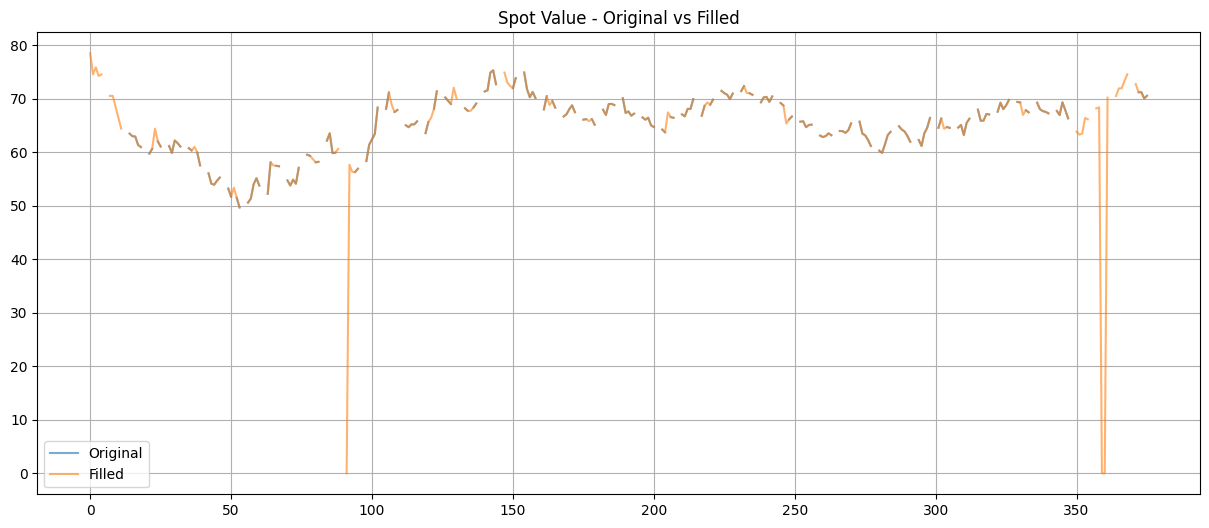

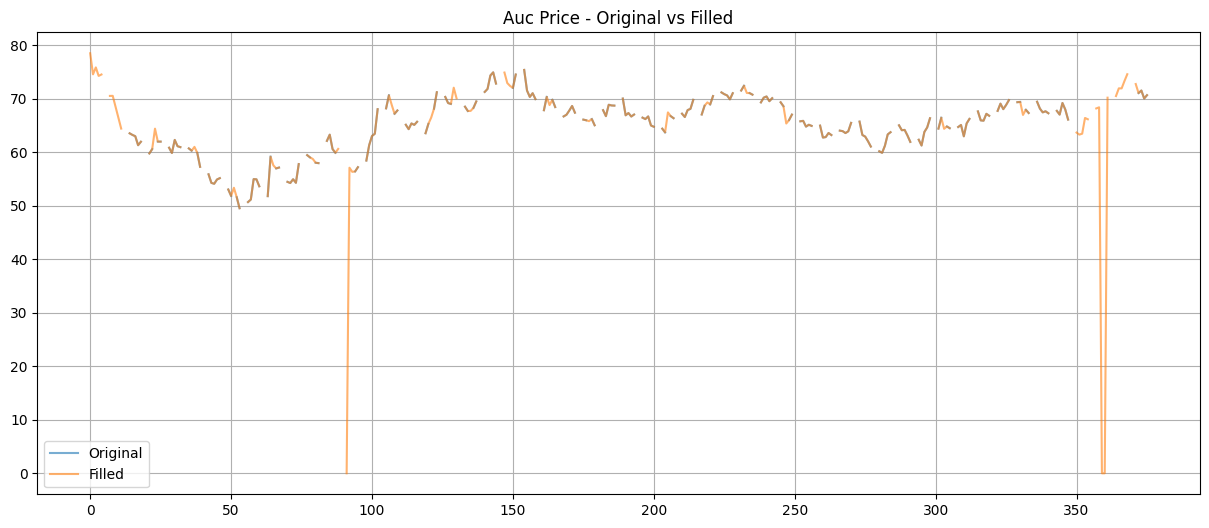

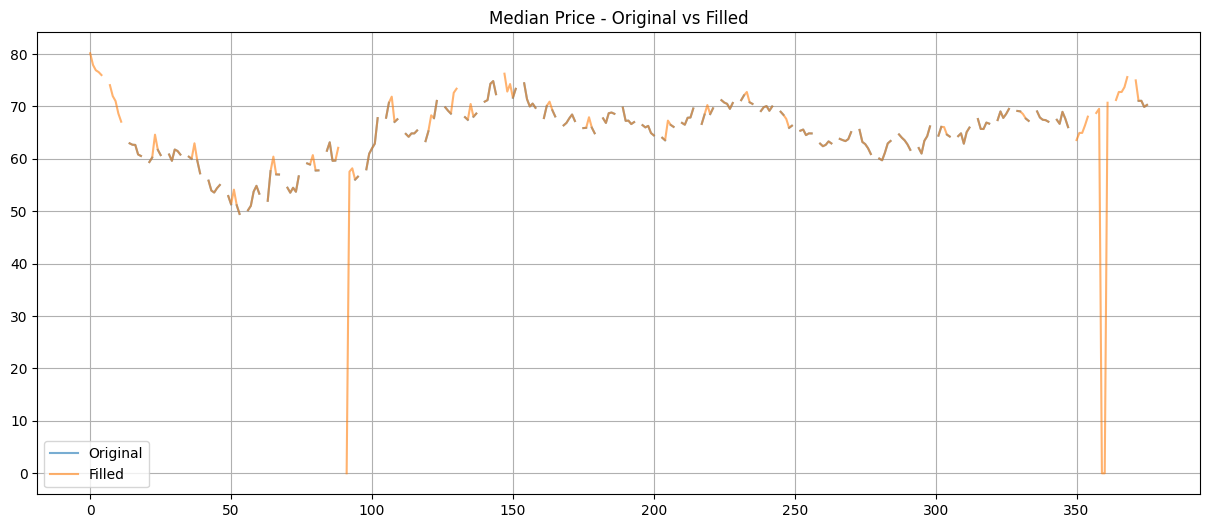

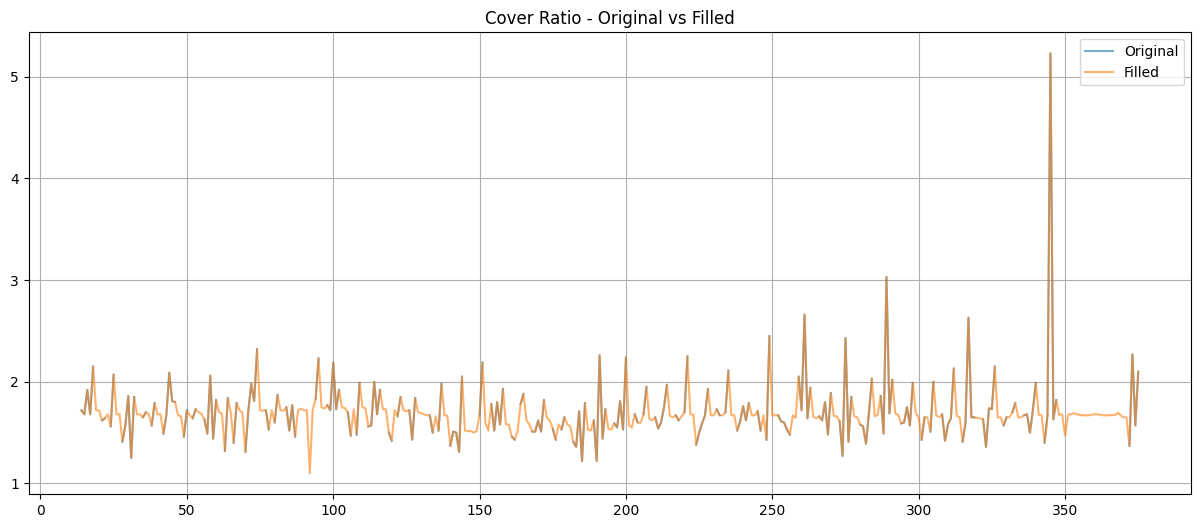

In [106]:
def plot_filling_results(original_df, filled_df, column):
    plt.figure(figsize=(15, 6))
    plt.plot(original_df.index, original_df[column], label='Original', alpha=0.6)
    plt.plot(filled_df.index, filled_df[column], label='Filled', alpha=0.6)
    plt.title(f'{column} - Original vs Filled')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for each filled column
for col in ['Spot Value', 'Auc Price', 'Median Price', 'Cover Ratio']:
    plot_filling_results(merged_df, filled_df, col)

In [4]:
auction_df = auction_df[7:]
auction_df.loc[:, 'Premium/discount-settle'] = auction_df['Premium/discount-settle'].ffill()
auction_df.loc[:, ['Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
                   'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']] = auction_df[['Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
                                                                                                      'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']].ffill()

auction_df

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
7,2018-06-11,15.70,15.59,2.03,15.69,0.01,-0.10,NaN
8,2018-06-12,15.08,15.13,1.63,15.20,-0.12,-0.07,NaN
9,2018-06-13,15.08,15.13,1.63,15.20,-0.12,-0.07,NaN
10,2018-06-14,15.44,15.30,2.27,15.39,0.05,-0.09,NaN
11,2018-06-15,14.62,14.69,1.68,14.79,-0.17,-0.10,NaN
...,...,...,...,...,...,...,...,...
2383,2024-12-12,67.95,67.68,1.63,67.89,0.06,-0.21,0.000884
2384,2024-12-13,66.07,66.05,1.82,66.35,-0.28,-0.30,-0.004220
2385,2024-12-14,66.07,66.05,1.82,66.35,-0.28,-0.30,-0.004220
2386,2024-12-15,66.07,66.05,1.82,66.35,-0.28,-0.30,-0.004220


In [5]:
auction_df[7:]

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
14,2018-06-18,14.52,14.39,2.03,14.44,0.08,-0.05,NaN
15,2018-06-19,14.35,14.24,2.19,14.37,-0.02,-0.13,NaN
16,2018-06-20,14.43,14.28,2.87,14.37,0.06,-0.09,NaN
17,2018-06-21,14.20,14.20,2.50,14.26,-0.06,-0.06,NaN
18,2018-06-22,14.78,14.65,3.45,14.70,0.08,-0.05,NaN
...,...,...,...,...,...,...,...,...
2383,2024-12-12,67.95,67.68,1.63,67.89,0.06,-0.21,0.000884
2384,2024-12-13,66.07,66.05,1.82,66.35,-0.28,-0.30,-0.004220
2385,2024-12-14,66.07,66.05,1.82,66.35,-0.28,-0.30,-0.004220
2386,2024-12-15,66.07,66.05,1.82,66.35,-0.28,-0.30,-0.004220


In [3]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()


auction_df = auction_df[7:]
auction_df.loc[:, 'Premium/discount-settle'] = auction_df['Premium/discount-settle'].ffill()
auction_df.loc[:, ['Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']] = auction_df[['Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value', 
                                                                                          'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']].ffill()

merged_df = DataPreprocessor.engineer_auction_features(auction_df)
# Define features and labels
FEATURES = merged_df.columns.tolist()
LABEL_COLS = ['Auc Price']

preprocessor = DataPreprocessor(features=FEATURES, label_columns=LABEL_COLS, input_width=7, label_width=7, shift=1)
train_df, test_df, val_df = preprocessor.train_test_data(merged_df)
train_df, test_df, val_df = preprocessor.normalize(train_df, test_df, val_df)
num_features = len(test_df.columns)

Train DF:             Auc Price  Median Price  Cover Ratio  Spot Value  \
Date                                                           
2018-06-11      15.70         15.59         2.03       15.69   
2018-06-12      15.08         15.13         1.63       15.20   
2018-06-13      15.08         15.13         1.63       15.20   
2018-06-14      15.44         15.30         2.27       15.39   
2018-06-15      14.62         14.69         1.68       14.79   

            Auction Spot Diff  Median Spot Diff  Premium/discount-settle  \
Date                                                                       
2018-06-11               0.01             -0.10                -0.002205   
2018-06-12              -0.12             -0.07                -0.002205   
2018-06-13              -0.12             -0.07                -0.002205   
2018-06-14               0.05             -0.09                -0.002205   
2018-06-15              -0.17             -0.10                -0.002205   

        

In [4]:
auction_df.head()

,Date,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
7,2018-06-11,15.70,15.59,2.03,15.69,0.01,-0.10,NaN
8,2018-06-12,15.08,15.13,1.63,15.20,-0.12,-0.07,NaN
9,2018-06-13,15.08,15.13,1.63,15.20,-0.12,-0.07,NaN
10,2018-06-14,15.44,15.30,2.27,15.39,0.05,-0.09,NaN
11,2018-06-15,14.62,14.69,1.68,14.79,-0.17,-0.10,NaN


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7860 - mean_absolute_error: 0.6675 - val_loss: 0.5517 - val_mean_absolute_error: 0.4587
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4544 - mean_absolute_error: 0.3757 - val_loss: 0.5004 - val_mean_absolute_error: 0.4112
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4124 - mean_absolute_error: 0.3499 - val_loss: 0.4442 - val_mean_absolute_error: 0.3735
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3681 - mean_absolute_error: 0.3246 - val_loss: 0.4004 - val_mean_absolute_error: 0.3388
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3464 - mean_absolute_error: 0.3034 - val_loss: 0.3790 - val_mean_absolute_error: 0.3169
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3218 - mean_absolute_error: 0.2855 - val_loss: 0.3654 - val_mean_absolute_error: 0.3060
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3049 - mean_absolute_error: 0.2752 - val_loss: 0.359

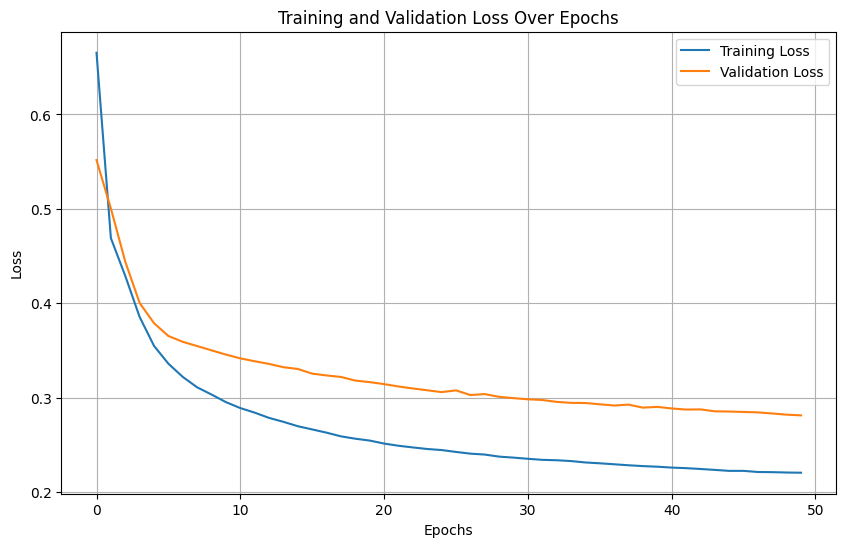

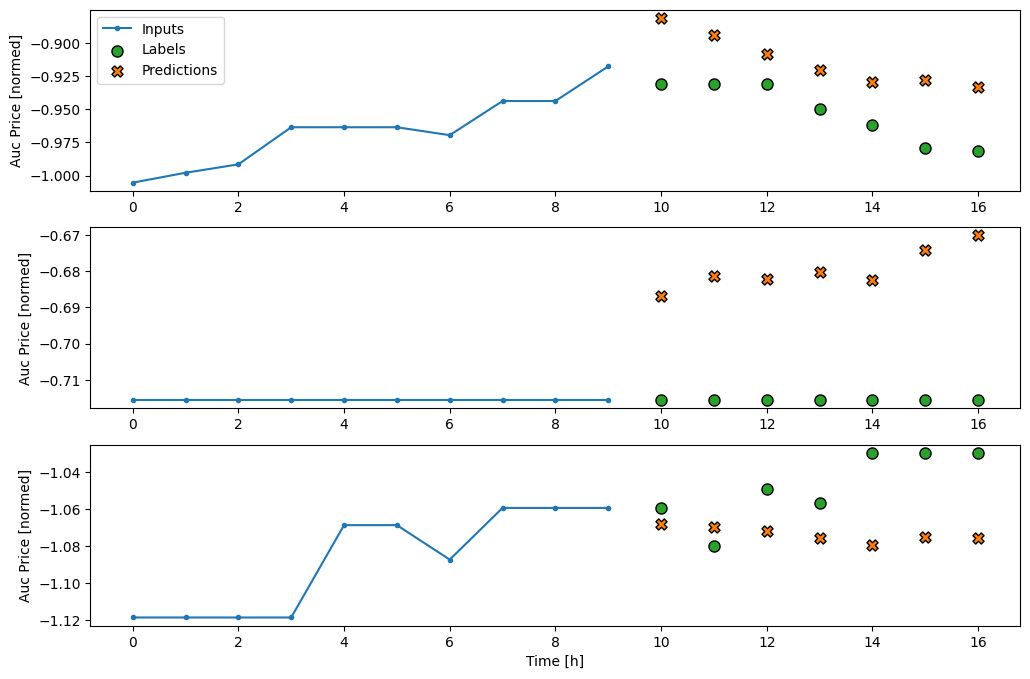

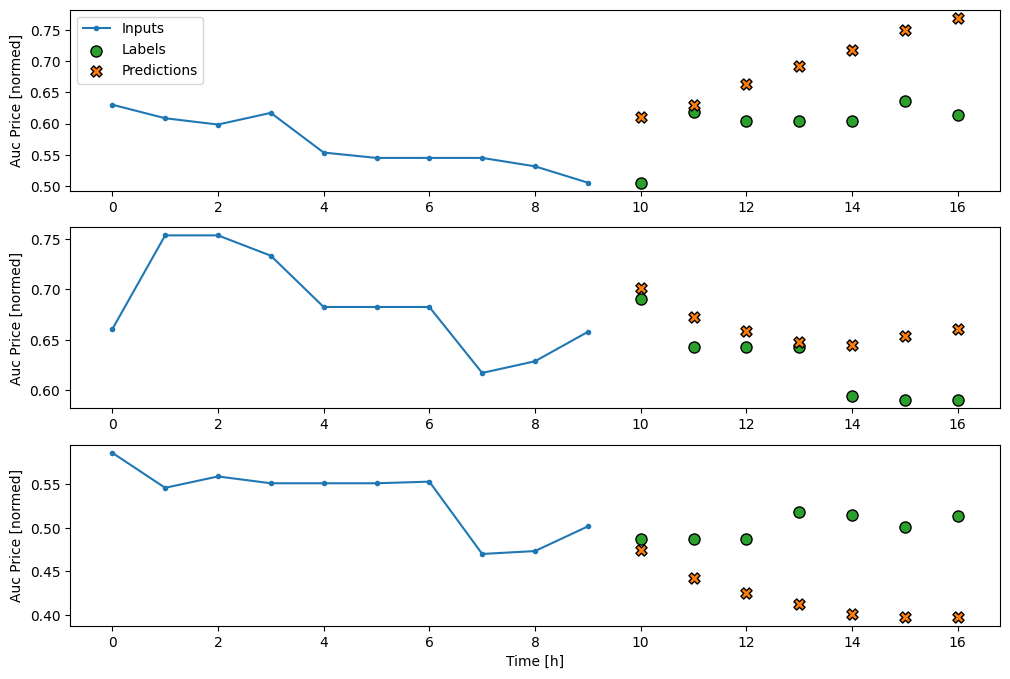

In [5]:
OUT_STEPS = 7
INPUT_WIDTH = 10
multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

def compile_and_fit(self, model: tf.keras.Model, 
                    window: WindowGenerator, 
                    patience: int = 2, 
                    max_epochs: int = 20,
                    use_early_stopping: bool = True):
        callbacks = []
        if use_early_stopping:
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
            callbacks.append(early_stopping)
        
        model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                    optimizer=tf.keras.optimizers.Adam(), 
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])
        
        history = model.fit(window.train, epochs=max_epochs, validation_data=window.val, callbacks=callbacks)
        return history

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = preprocessor.compile_and_fit(multi_lstm_model, multi_window, use_early_stopping=False, max_epochs=50)

Plotting.plot_history(history)
multi_window.plot(multi_lstm_model)
multi_window.plot_test(multi_lstm_model)

In [41]:
import os

MODEL_DIR = Path('../models')

In [9]:
def sequential_predict_and_plot(model, test_df, input_width, out_steps, features):
    num_features = len(features)
    predictions = []
    inputs = test_df.iloc[:input_width].values

    for i in range(input_width, len(test_df) - out_steps + 1, out_steps):
        inputs = inputs[-input_width:]
        if inputs.shape[0] != input_width or inputs.shape[1] != num_features:
            raise ValueError(f"Expected input shape ({input_width}, {num_features}), but got {inputs.shape}")
        inputs_reshaped = inputs.reshape((1, input_width, num_features))
        preds = model.predict(inputs_reshaped)
        predictions.append(preds[0])
        # inputs = np.concatenate([inputs, preds[0]])
        inputs = np.concatenate([inputs, test_df.iloc[i:i+out_steps].values])

    predictions = np.concatenate(predictions, axis=0)
    predictions_df = pd.DataFrame(predictions, columns=features, index=test_df.index[input_width:input_width + len(predictions)])

    plt.figure(figsize=(12, 6))
    plt.plot(test_df.index, test_df['Auc Price'], label='Actual Auc Price')
    plt.plot(predictions_df.index, predictions_df['Auc Price'], label='Predicted Auc Price', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Auc Price')
    plt.title('Actual vs Predicted Auc Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [49]:
multi_lstm_model.save('models/multi_lstm_model.keras')

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def check_gradient(values):
        gradient = np.gradient(values)
        return 'positive' if np.all(gradient > 0) else 'negative'

def plot_model_results(model, test_df, input_width, out_steps):
    features = test_df.columns
    num_features = len(features)
    predictions = []
    inputs = test_df.iloc[:input_width].values

    

    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        try:    
            inputs = test_df[i-input_width:i].values
            inputs_reshaped = inputs.reshape((1, input_width, num_features))

            preds = model.predict(inputs_reshaped)
            predictions.append(preds[0])
            inputs = np.concatenate([inputs, test_df[i:i+out_steps].values])
        except Exception as e:
            break

    predictions = np.concatenate(predictions, axis=0)
    predictions_df = pd.DataFrame(predictions, columns=features, index=test_df.index[input_width:input_width + len(predictions)])

    plt.figure(figsize=(12, 5))
    plt.plot(test_df.index, test_df['Auc Price'], label='Actual Auc Price')

    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        trend = check_gradient(predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps].values)
        single_point_index = predictions_df.index[idx* out_steps:(idx+1)* out_steps][0]
        single_point_value = test_df[test_df.index == single_point_index]['Auc Price'].values[0]
        prev_timestamp = single_point_index - pd.to_timedelta(1, unit='d')
        prev_auc_price = test_df[test_df.index == prev_timestamp]['Auc Price'].values[0]
        pred_diff = np.mean(predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps].values) - prev_auc_price

        if pred_diff > 0:
            plt.scatter(single_point_index, single_point_value, color='green', marker='o')
            plt.text(single_point_index, single_point_value, "Buy", fontsize=8, verticalalignment='top')
            plt.plot(predictions_df.index[idx* out_steps:(idx+1)* out_steps], 
                 predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps], 
                 label=f'Predicted Auc Price {idx+1}', linestyle='dashed', color='green')
        else: 
            plt.scatter(single_point_index, single_point_value, color='red', marker='o')
            plt.text(single_point_index, single_point_value, "Sell", fontsize=8, verticalalignment='top')
            plt.plot(predictions_df.index[idx* out_steps:(idx+1)* out_steps], 
                 predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps], 
                 label=f'Predicted Auc Price {idx+1}', linestyle='dashed', color='red')
            

    # inputs = test_df[-14:-7].values
    # inputs_reshaped = inputs.reshape((1, 7, num_features))
    # preds = model.predict(inputs_reshaped)
    # predictions = []
    # predictions.append(preds[0])
    # predictions = np.concatenate(predictions, axis=0)
    # start_date = test_df.index[-7] + datetime.timedelta(days=1)
    # date_range = pd.date_range(start=start_date, periods=7)
    # recent_preds = pd.DataFrame(predictions, index=date_range, columns=FEATURES[1:])
    # trend = check_gradient(recent_preds['Auc Price'])
    # plt.plot(recent_preds.index, recent_preds['Auc Price'], color='red', marker='x', label="recent_prediction", alpha=0.4)

    inputs = test_df[-7:].values
    inputs_reshaped = inputs.reshape((1, 7, num_features))
    preds = model.predict(inputs_reshaped)
    predictions = []
    predictions.append(preds[0])
    predictions = np.concatenate(predictions, axis=0)
    start_date = test_df.index[-1] + datetime.timedelta(days=1)
    date_range = pd.date_range(start=start_date, periods=7)
    recent_preds = pd.DataFrame(predictions, index=date_range, columns=FEATURES[1:])
    trend = check_gradient(recent_preds['Auc Price'])
    recent_preds = pd.concat([test_df.iloc[[-1]], recent_preds])
    pred_diff = np.mean(recent_preds.iloc[1:]['Auc Price'].values) - recent_preds.iloc[1]['Auc Price']

    if pred_diff > 0:
        plt.text(recent_preds.index[0], recent_preds.iloc[0]['Auc Price'], "Buy", fontsize=8, verticalalignment='top')
        plt.plot(recent_preds.index, recent_preds['Auc Price'], color='green', marker='x', label="recent_prediction2", alpha=0.4)
    else: 
        plt.text(recent_preds.index[0], recent_preds.iloc[0]['Auc Price'], "Sell", fontsize=8, verticalalignment='top')
        plt.plot(recent_preds.index, recent_preds['Auc Price'], color='red', marker='x', label="recent_prediction2", alpha=0.4)

    
    # predictions.append(preds[0])

    plt.xlabel('Date')
    plt.ylabel('Auc Price')
    plt.title('Actual vs Predicted Auc Price')
    plt.grid(True)
    plt.show()


# •Predictions Generation: The script uses the model to generate predictions on the test data in steps of out_steps. It reshapes the inputs accordingly and collects the predictions.
# •Signal Determination: For each prediction window, it calculates the mean predicted price and compares it to the previous day’s actual price to decide whether to ‘Buy’ or ‘Sell’.
# •Trade Simulation: It simulates the trade over the next out_steps days, checking each day if the take profit or stop loss levels are hit. If neither is hit, it closes the trade at the last available price in the window.
# •Profit/Loss Calculation: The profit or loss for each trade is calculated based on the entry and exit prices and the position size.
# •Balance Update: The script updates the account balance after each trade and logs the trade details.
# •Outputs: At the end, it returns a DataFrame containing the trade log, the total return from backtesting, and the balance history.
def backtest_model(model, test_df, input_width, out_steps, initial_balance, take_profit, stop_loss):
    """
    Backtesting function for the given model and test data.

    Parameters:
    - model: The trained prediction model.
    - test_df: DataFrame containing test data with 'Auc Price' column.
    - input_width: The number of past days used for making predictions.
    - out_steps: The number of future days the model predicts.
    - initial_balance: Initial amount of money in the account.
    - take_profit: Profit percentage at which to close the trade.
    - stop_loss: Loss percentage at which to close the trade.

    Returns:
    - trade_log_df: DataFrame containing the log of trades executed.
    - total_return: Total return from the backtesting.
    - balance_history: List containing the balance after each trade.
    """
    features = test_df.columns
    num_features = len(features)
    predictions = []

    # Initialize balance and trade log
    balance = initial_balance
    balance_history = [balance]
    trade_log = []
    position_size = initial_balance  # Using full balance per trade for simplicity

    # Generate predictions in steps of 'out_steps'
    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        try:
            inputs = test_df[i - input_width:i].values
            inputs_reshaped = inputs.reshape((1, input_width, num_features))
            preds = model.predict(inputs_reshaped)
            predictions.append(preds[0])
        except Exception as e:
            print(f"Prediction error at index {i}: {e}")
            break

    # Create DataFrame for predictions
    predictions = np.concatenate(predictions, axis=0)
    pred_indices = test_df.index[input_width:input_width + len(predictions)]
    predictions_df = pd.DataFrame(predictions, columns=features, index=pred_indices)

    # Simulate trades based on predictions
    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        entry_index = predictions_df.index[idx * out_steps]
        entry_price = test_df.loc[entry_index, 'Auc Price']
        prev_index = entry_index - pd.Timedelta(days=1)
        prev_price = test_df.loc[prev_index, 'Auc Price'] if prev_index in test_df.index else entry_price

        # Determine signal based on predicted mean price
        pred_mean = predictions_df['Auc Price'][idx * out_steps:(idx + 1) * out_steps].mean()
        signal = 'Buy' if pred_mean > prev_price else 'Sell'

        trade_closed = False
        exit_price = None
        exit_date = None

        # Simulate trade over the next 'out_steps' days
        for offset in range(1, out_steps + 1):
            current_index = entry_index + pd.Timedelta(days=offset)
            if current_index not in test_df.index:
                continue
            current_price = test_df.loc[current_index, 'Auc Price']

            # Calculate return percentage
            if signal == 'Buy':
                return_pct = (current_price - entry_price) / entry_price
                if return_pct >= take_profit:
                    exit_price = entry_price * (1 + take_profit)
                    exit_date = current_index
                    trade_closed = True
                    break
                elif return_pct <= -stop_loss:
                    exit_price = entry_price * (1 - stop_loss)
                    exit_date = current_index
                    trade_closed = True
                    break
            else:  # Sell signal
                return_pct = (entry_price - current_price) / entry_price
                if return_pct >= take_profit:
                    exit_price = entry_price * (1 - take_profit)
                    exit_date = current_index
                    trade_closed = True
                    break
                elif return_pct <= -stop_loss:
                    exit_price = entry_price * (1 + stop_loss)
                    exit_date = current_index
                    trade_closed = True
                    break

        # If trade not closed, close at the last available price
        if not trade_closed:
            last_index = entry_index + pd.Timedelta(days=out_steps)
            while last_index not in test_df.index and last_index > entry_index:
                last_index -= pd.Timedelta(days=1)
            if last_index in test_df.index:
                exit_price = test_df.loc[last_index, 'Auc Price']
                exit_date = last_index
            else:
                # If exit price not found, skip the trade
                print(f"Exit price not found for trade starting on {entry_index}")
                continue

        # Calculate profit or loss
        if signal == 'Buy':
            profit_loss = (exit_price - entry_price) / entry_price * position_size
        else:  # Sell
            profit_loss = (entry_price - exit_price) / entry_price * position_size

        # Update balance and log the trade
        balance += profit_loss
        balance_history.append(balance)
        trade_log.append({
            'Entry Date': entry_index,
            'Exit Date': exit_date,
            'Signal': signal,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Profit/Loss': profit_loss,
            'Balance': balance
        })

    # Convert trade log to DataFrame
    trade_log_df = pd.DataFrame(trade_log)

    # Calculate total return
    total_return = (balance - initial_balance) / initial_balance

    return trade_log_df, total_return, balance_history

def backtest_model_with_metrics(
    model, test_df, input_width, out_steps,
    initial_balance, take_profit, stop_loss,
    position_size_fraction=0.1,  # 10% of current balance per trade
    risk_free_rate=0.01  # Annual risk-free rate for Sharpe ratio
):
    """
    Backtesting function for the given model and test data with position sizing and performance metrics.

    Parameters:
    - model: The trained prediction model.
    - test_df: DataFrame containing test data with 'Auc Price' column.
    - input_width: The number of past days used for making predictions.
    - out_steps: The number of future days the model predicts.
    - initial_balance: Initial amount of money in the account.
    - take_profit: Profit percentage at which to close the trade.
    - stop_loss: Loss percentage at which to close the trade.
    - position_size_fraction: Fraction of current balance to use per trade.
    - risk_free_rate: Risk-free rate for performance metrics calculations.

    Returns:
    - trade_log_df: DataFrame containing the log of trades executed.
    - performance_metrics: Dictionary containing various performance metrics.
    - balance_history: DataFrame containing balance history over time.
    """
    features = test_df.columns
    num_features = len(features)
    predictions = []

    # Initialize balance and trade log
    balance = initial_balance
    balance_history = []
    trade_log = []

    # For performance metrics
    returns = []
    equity_curve = [initial_balance]

    # Generate predictions in steps of 'out_steps'
    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        try:
            inputs = test_df[i - input_width:i].values
            inputs_reshaped = inputs.reshape((1, input_width, num_features))
            preds = model.predict(inputs_reshaped)
            predictions.append(preds[0])
        except Exception as e:
            print(f"Prediction error at index {i}: {e}")
            break

    # Create DataFrame for predictions
    predictions = np.concatenate(predictions, axis=0)
    pred_indices = test_df.index[input_width:input_width + len(predictions)]
    predictions_df = pd.DataFrame(predictions, columns=features, index=pred_indices)

    # Simulate trades based on predictions
    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        entry_index = predictions_df.index[idx * out_steps]
        entry_price = test_df.loc[entry_index, 'Auc Price']
        prev_index = entry_index - pd.Timedelta(days=1)
        prev_price = test_df.loc[prev_index, 'Auc Price'] if prev_index in test_df.index else entry_price

        # Determine signal based on predicted mean price
        pred_mean = predictions_df['Auc Price'][idx * out_steps:(idx + 1) * out_steps].mean()
        signal = 'Buy' if pred_mean > prev_price else 'Sell'

        trade_closed = False
        exit_price = None
        exit_date = None

        # Position sizing
        position_size = balance * position_size_fraction

        # Simulate trade over the next 'out_steps' days
        for offset in range(1, out_steps + 1):
            current_index = entry_index + pd.Timedelta(days=offset)
            if current_index not in test_df.index:
                continue
            current_price = test_df.loc[current_index, 'Auc Price']

            # Calculate return percentage
            if signal == 'Buy':
                return_pct = (current_price - entry_price) / entry_price
                if return_pct >= take_profit:
                    exit_price = entry_price * (1 + take_profit)
                    exit_date = current_index
                    trade_closed = True
                    break
                elif return_pct <= -stop_loss:
                    exit_price = entry_price * (1 - stop_loss)
                    exit_date = current_index
                    trade_closed = True
                    break
            else:  # Sell signal
                return_pct = (entry_price - current_price) / entry_price
                if return_pct >= take_profit:
                    exit_price = entry_price * (1 - take_profit)
                    exit_date = current_index
                    trade_closed = True
                    break
                elif return_pct <= -stop_loss:
                    exit_price = entry_price * (1 + stop_loss)
                    exit_date = current_index
                    trade_closed = True
                    break

        # If trade not closed, close at the last available price
        if not trade_closed:
            last_index = entry_index + pd.Timedelta(days=out_steps)
            while last_index not in test_df.index and last_index > entry_index:
                last_index -= pd.Timedelta(days=1)
            if last_index in test_df.index:
                exit_price = test_df.loc[last_index, 'Auc Price']
                exit_date = last_index
            else:
                # If exit price not found, skip the trade
                print(f"Exit price not found for trade starting on {entry_index}")
                continue

        # Calculate profit or loss
        if signal == 'Buy':
            profit_loss = (exit_price - entry_price) / entry_price * position_size
        else:  # Sell
            profit_loss = (entry_price - exit_price) / entry_price * position_size

        # Update balance and log the trade
        balance += profit_loss
        returns.append(profit_loss / position_size)  # Return percentage for this trade
        equity_curve.append(balance)
        balance_history.append({'Date': exit_date, 'Balance': balance})

        trade_log.append({
            'Entry Date': entry_index,
            'Exit Date': exit_date,
            'Signal': signal,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Profit/Loss': profit_loss,
            'Return (%)': (profit_loss / position_size) * 100,
            'Balance': balance
        })

    # Convert trade log and balance history to DataFrames
    trade_log_df = pd.DataFrame(trade_log)
    balance_history_df = pd.DataFrame(balance_history).set_index('Date')

    # Calculate performance metrics
    total_return = (balance - initial_balance) / initial_balance
    num_years = (test_df.index[-1] - test_df.index[input_width]).days / 365.25
    CAGR = (balance / initial_balance) ** (1 / num_years) - 1 if num_years > 0 else 0

    # Maximum Drawdown
    equity_series = pd.Series(equity_curve)
    cumulative_returns = equity_series / equity_series.cummax() - 1
    max_drawdown = cumulative_returns.min()

    # Sharpe Ratio
    excess_returns = np.array(returns) - (risk_free_rate / 252)
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252) if np.std(excess_returns) != 0 else np.nan

    # Sortino Ratio
    negative_returns = excess_returns[excess_returns < 0]
    downside_std = np.std(negative_returns)
    sortino_ratio = np.mean(excess_returns) / downside_std * np.sqrt(252) if downside_std != 0 else np.nan

    # Win Rate
    num_trades = len(trade_log_df)
    num_wins = len(trade_log_df[trade_log_df['Profit/Loss'] > 0])
    win_rate = num_wins / num_trades if num_trades > 0 else np.nan

    # Average Profit per Trade
    avg_profit = trade_log_df['Profit/Loss'].mean()

    # Profit Factor
    gross_profit = trade_log_df[trade_log_df['Profit/Loss'] > 0]['Profit/Loss'].sum()
    gross_loss = -trade_log_df[trade_log_df['Profit/Loss'] < 0]['Profit/Loss'].sum()
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan

    performance_metrics = {
        'Total Return (%)': total_return * 100,
        'CAGR (%)': CAGR * 100,
        'Maximum Drawdown (%)': max_drawdown * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Win Rate (%)': win_rate * 100,
        'Average Profit per Trade': avg_profit,
        'Profit Factor': profit_factor
    }

    return trade_log_df, performance_metrics, balance_history_df

In [65]:
recent_preds['Auc Price'].values

array([0.47000937, 0.24076563, 0.19233224, 0.15161052, 0.17092502,
       0.15077357, 0.19588479, 0.13900527])

In [62]:
def check_gradient(values):
    gradient = np.gradient(values)
    return 'positive' if np.all(gradient > 0) else 'negative'

In [64]:
np.gradient(recent_preds['Auc Price'].values)

array([-0.22924374, -0.13883857, -0.04457755, -0.01070361, -0.00041848,
        0.01247989, -0.00588415, -0.05687952])

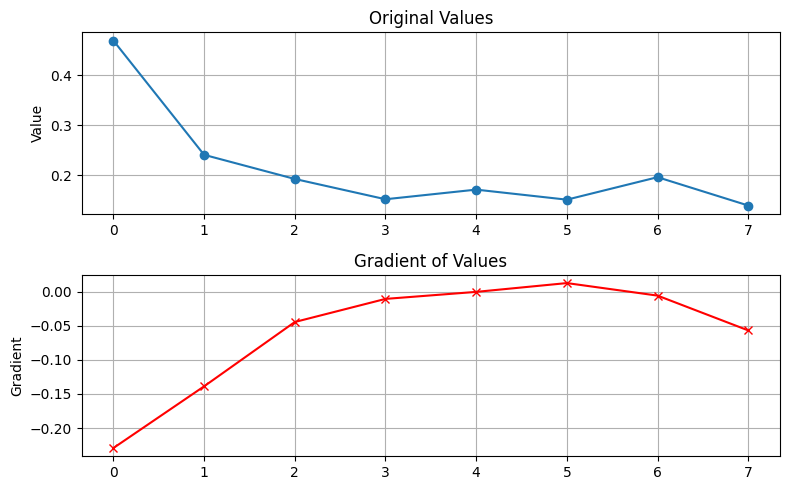

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Define the array
values = np.array([0.47000937, 0.24076563, 0.19233224, 0.15161052, 0.17092502,
                   0.15077357, 0.19588479, 0.13900527])

# Calculate the gradient of the array
gradient = np.gradient(values)

# Plot the original values and their gradient
plt.figure(figsize=(8, 5))

# Plot the original values
plt.subplot(2, 1, 1)
plt.plot(values, marker='o', label='Original Values')
plt.title('Original Values')
plt.ylabel('Value')
plt.grid(True)

# Plot the gradient
plt.subplot(2, 1, 2)
plt.plot(gradient, marker='x', color='r', label='Gradient')
plt.title('Gradient of Values')
plt.ylabel('Gradient')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [48]:
recent_preds

,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,DayOfWeek,Month,Quarter,...,Auc_Spot_Sum,Auc_to_Median_Spot_Ratio,Auc_Price_Squared,Cover_Ratio_Squared,Auc_Price_DayOfWeek_Interaction,Auc_Price_Month_Interaction,Auc_Price_Lag_Interaction,Auc_Price_RSI_Interaction,Complex_Interaction_1,Complex_Interaction_2
2024-09-18,0.240766,0.238161,-0.578367,0.259332,-0.339423,-0.993774,-0.555402,-0.392485,0.733558,0.699410,...,0.249725,-0.351630,0.079958,-0.666869,-0.441096,0.895430,0.151574,-1.299795,-0.583545,0.579558
2024-09-19,0.192332,0.202465,-0.624713,0.203956,-0.731215,-0.365341,-0.771696,-0.069028,0.768583,0.677932,...,0.198180,-0.367321,-0.027305,-0.488269,0.006472,0.881837,0.029041,-1.559789,-0.659374,-0.119915
2024-09-20,0.151611,0.144558,-0.450183,0.133982,0.552394,-0.192399,0.278809,0.731629,0.898900,0.755171,...,0.142365,-0.287365,-0.057252,-0.257261,1.088626,0.949741,-0.044146,-1.418136,-0.453753,0.736069
2024-09-21,0.170925,0.156412,0.174108,0.155099,0.511090,-0.397303,0.635052,0.438390,0.851518,0.720413,...,0.163396,-0.263816,-0.006162,0.310030,0.835234,0.942781,-0.037567,-1.283637,0.177605,0.883904
2024-09-22,0.150774,0.123387,0.106276,0.123947,1.162825,-0.259898,1.376159,1.246351,0.826333,0.690772,...,0.138555,-0.312542,-0.034520,0.183706,1.456039,0.954168,-0.033145,-1.159351,0.135511,1.277849
2024-09-23,0.195885,0.189614,-0.402584,0.189991,0.680086,0.311227,0.665169,-1.546123,0.880119,0.703410,...,0.194377,-0.268106,-0.023649,-0.300399,-1.115584,1.024393,-0.037443,-1.269909,-0.372925,0.739155
2024-09-24,0.139005,0.128716,-0.406630,0.137421,0.529945,0.645761,0.229160,-0.302423,0.775622,0.608830,...,0.138829,-0.235704,-0.124758,-0.364251,-1.012815,0.916107,-0.068689,-1.423913,-0.400619,0.842251


In [53]:
recent_preds = pd.concat([test_df.iloc[[-1]], recent_preds])

-0.06343748101166316

In [7]:
# Assuming you have your model, test_df, input_width, and out_steps defined
initial_balance = 10000  # Starting with $10,000
take_profit = 0.05       # 5% take profit
stop_loss = 0.01         # 2% stop loss

trade_log_df, total_return, balance_history = backtest_model(
    multi_lstm_model,
    test_df,
    INPUT_WIDTH,
    OUT_STEPS,
    initial_balance,
    take_profit,
    stop_loss
)

print(trade_log_df)
print(f"Total Return: {total_return * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
   Entry Date  Exit Date Signal  Entry Price  Exit Price  Profit/Loss  Balance
0  2024-04-11 2024-04-12   Sell 

In [13]:
trade_log_df['Entry Price']

0     0.496488
1     0.635596
2     0.558397
3     0.671026
4     0.704218
5     0.676993
6     0.924628
7     0.816474
8     0.779180
9     0.733308
10    0.690046
11    0.599048
12    0.693776
13    0.616576
14    0.553922
15    0.619187
16    0.669907
17    0.700861
18    0.736291
19    0.779926
20    0.723238
21    0.592335
22    0.559143
23    0.501710
Name: Entry Price, dtype: float64

In [12]:
preprocessor.train_mean['Auc Price']
preprocessor.train_std['Auc Price']

26.81370389150131

In [34]:
# Assuming you have your model, test_df, input_width, and out_steps defined
initial_balance = 10000  # Starting with $10,000
take_profit = 0.05       # 5% take profit
stop_loss = 0.02         # 2% stop loss
position_size_fraction = 1  # Use 10% of current balance per trade

trade_log_df, performance_metrics, balance_history_df = backtest_model_with_metrics(
    multi_lstm_model,
    test_df,
    10,
    7,
    initial_balance,
    take_profit,
    stop_loss,
    position_size_fraction=position_size_fraction
)

print(trade_log_df)
print("\nPerformance Metrics:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
   Entry Date  Exit Date Signal  Entry Price  Exit Price  Profit/Loss  \
0  2024-04-11 2024-04-12   Sell     0.492742    0.502597  -200.000000   
1  2024-04-18 2024-04-19   Sell     0.632016    0.644656  -196.000000   
2  2024-04-25 2024-04-29    Buy     0.554724    0.543630  -192.080000   
3  2024-05-02 2024-05-03    Buy     0.667488    0.700862   470.596000   
4  2024-05-09 2024-05-14   Sell     0.700719    0.665683   494.125800   
5  202

In [56]:
balance_history_df.reset_index()

Date              datetime64[ns]
Balance                  float64
Cumulative Max           float64
Drawdown                 float64
dtype: object

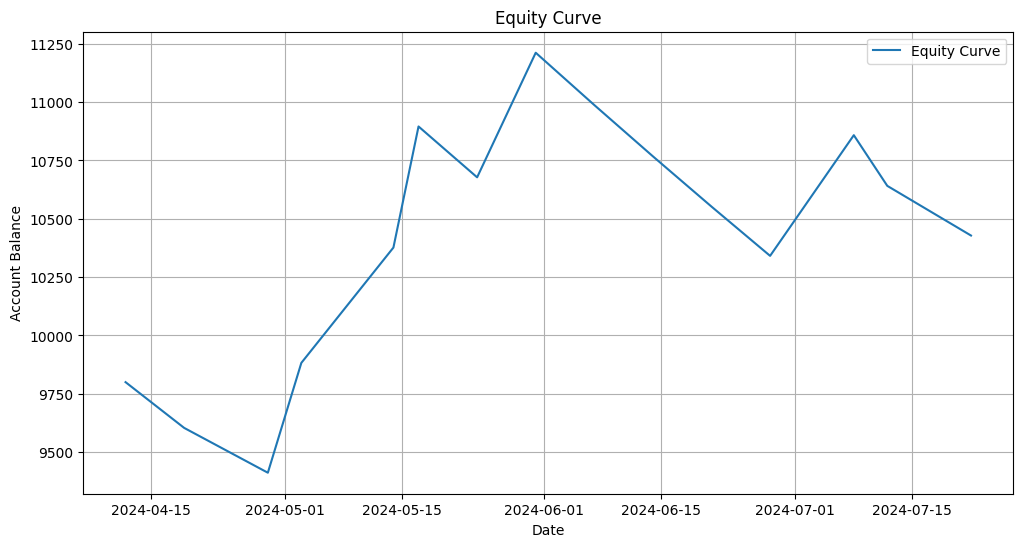

In [36]:
import matplotlib.pyplot as plt

# Plot Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(balance_history_df.index, balance_history_df['Balance'], label='Equity Curve')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Account Balance')
plt.legend()
plt.grid(True)
plt.show()

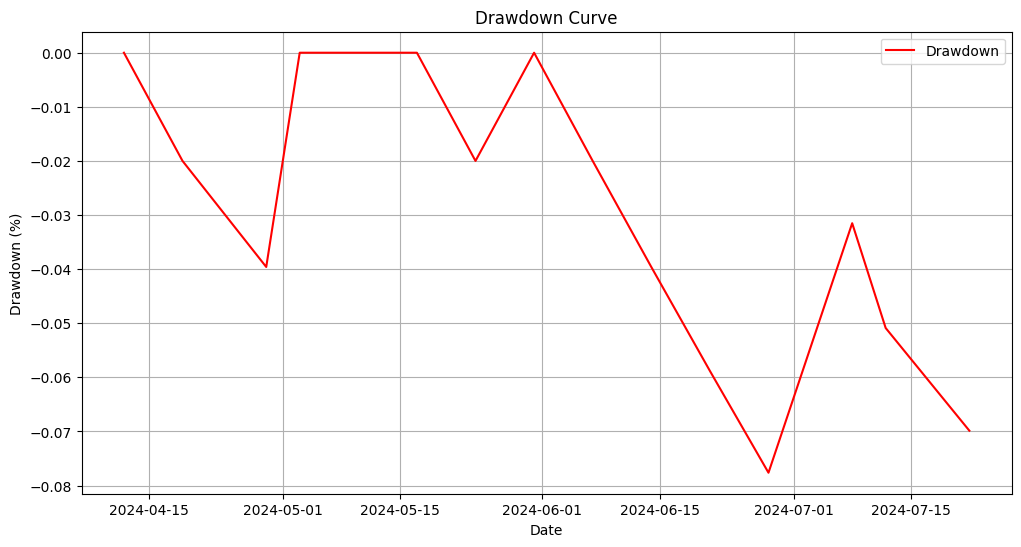

In [37]:
# Calculate Drawdown
balance_history_df['Cumulative Max'] = balance_history_df['Balance'].cummax()
balance_history_df['Drawdown'] = balance_history_df['Balance'] / balance_history_df['Cumulative Max'] - 1

# Plot Drawdown
plt.figure(figsize=(12, 6))
plt.plot(balance_history_df.index, balance_history_df['Drawdown'], label='Drawdown', color='red')
plt.title('Drawdown Curve')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


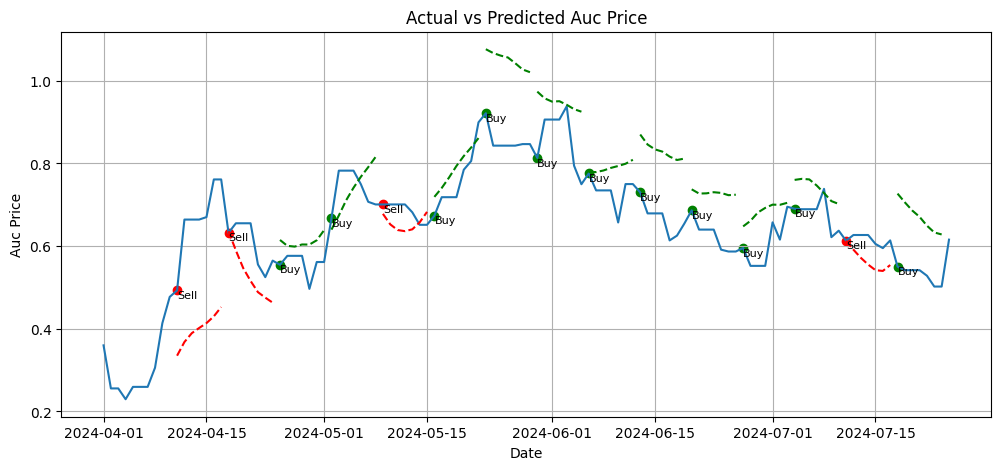

In [13]:
plot_model_results(multi_lstm_model, test_df, INPUT_WIDTH, OUT_STEPS)


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5597 - mean_absolute_error: 0.4858 - val_loss: 0.3553 - val_mean_absolute_error: 0.2972
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3042 - mean_absolute_error: 0.2695 - val_loss: 0.3247 - val_mean_absolute_error: 0.2786
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2787 - mean_absolute_error: 0.2488 - val_loss: 0.3095 - val_mean_absolute_error: 0.2662
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2575 - mean_absolute_error: 0.2375 - val_loss: 0.3023 - val_mean_absolute_error: 0.2637
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2544 - mean_absolute_error: 0.2339 - val_loss: 0.2961 - val_mean_absolute_error: 0.2597
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2449 - mean_absolute_error: 0.2310 - val_loss: 0.2928 - val_mean_absolute_error: 0.2558
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2480 - mean_absolute_error: 0.2292 - val_loss: 0.287

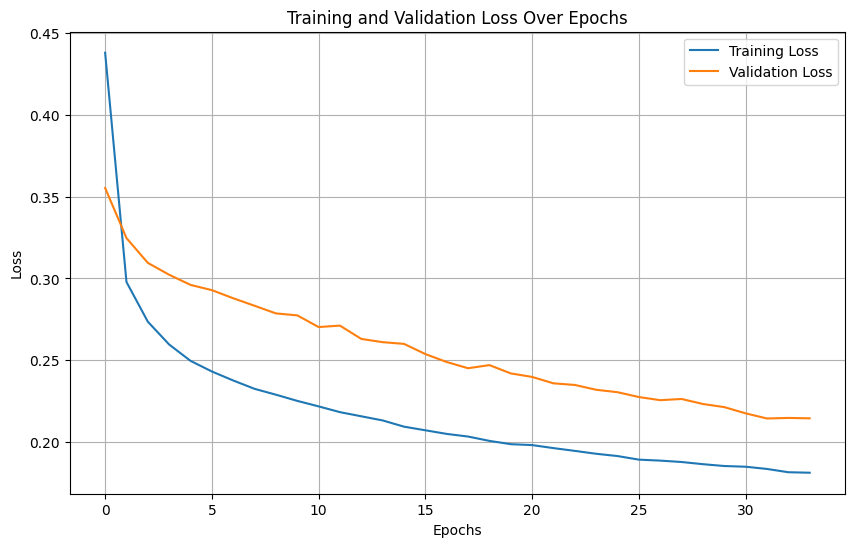

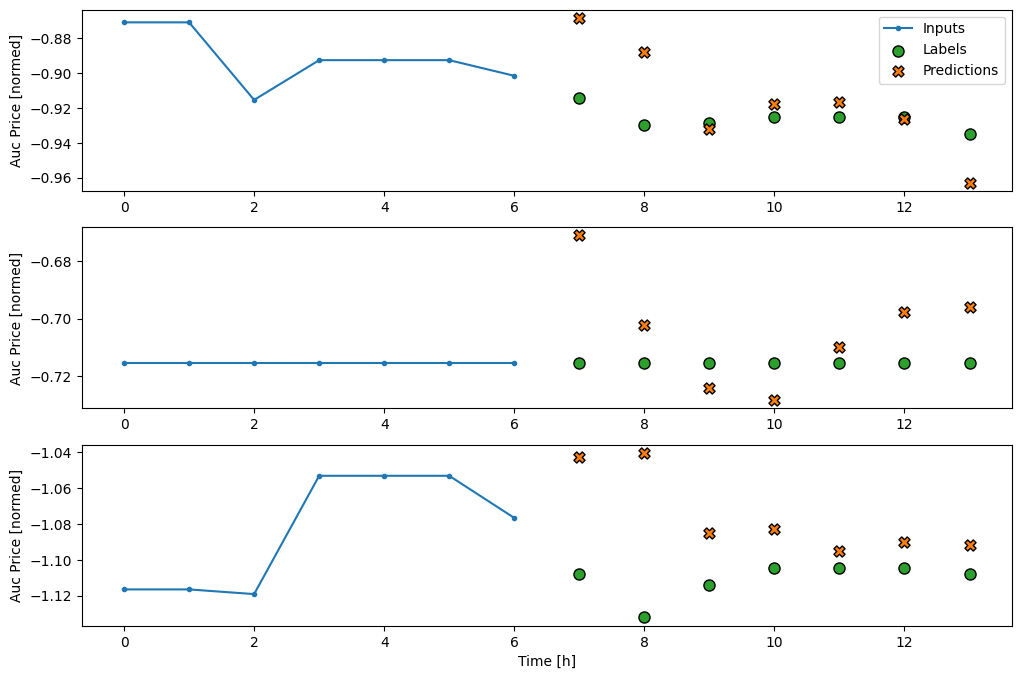

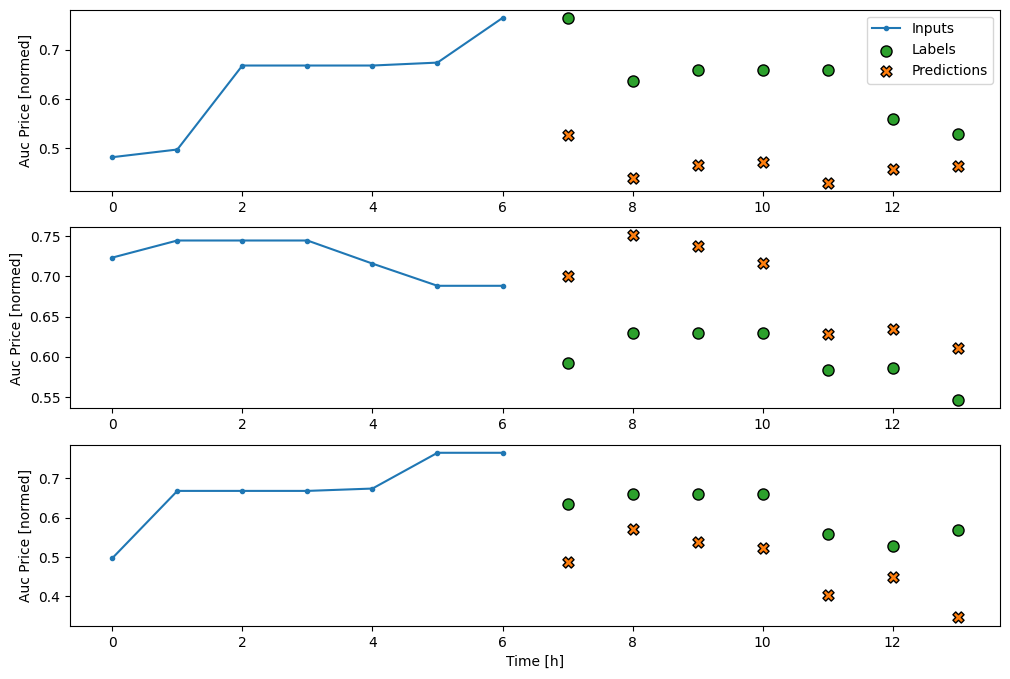

In [6]:
OUT_STEPS = 7
INPUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = preprocessor.compile_and_fit(multi_conv_model, multi_window, use_early_stopping=True, max_epochs=50)
# multi_val_performance['Multi Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
# multi_performance['Multi Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=1, return_dict=True)
Plotting.plot_history(history)
multi_window.plot(multi_conv_model)
multi_window.plot_test(multi_conv_model)

In [50]:
multi_conv_model.save('models/multi_conv_model.keras')

In [30]:
# Assuming you have your model, test_df, input_width, and out_steps defined
initial_balance = 10000  # Starting with $10,000
take_profit = 0.05       # 5% take profit
stop_loss = 0.01         # 2% stop loss

trade_log_df, total_return, balance_history = backtest_model(
    multi_conv_model,
    test_df,
    INPUT_WIDTH,
    OUT_STEPS,
    initial_balance,
    take_profit,
    stop_loss
)

print(trade_log_df)
print(f"Total Return: {total_return * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
   Entry Date  Exit Date Signal  Entry Price  Exit Price  Profit/Loss  Balance
0  2024-04-11 2024-04-12    Buy     0.492742    0.517379        500.0  10500.0
1  2024-04-18 2024-04-19   Sell     0.632016    0.638336       -100.0  10400.0
2  2024-04-25 2024-04-29    Buy     0.554724    0.549177       -100.0  10300.0
3  2024-05-02 2024-05-03    Buy     0.667488    0.700862        500.0  10800.0
4  2024-05-09 2024-05-13    Buy     0.700719    0.

In [31]:
total_return

0.3300000000000009

In [32]:
# Assuming you have your model, test_df, input_width, and out_steps defined
initial_balance = 10000  # Starting with $10,000
take_profit = 0.05       # 5% take profit
stop_loss = 0.02         # 2% stop loss
position_size_fraction = 1  # Use 10% of current balance per trade

trade_log_df, performance_metrics, balance_history_df = backtest_model_with_metrics(
    multi_conv_model,
    test_df,
    7,
    7,
    initial_balance,
    take_profit,
    stop_loss,
    position_size_fraction=position_size_fraction
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [68]:
pd.DataFrame(performance_metrics.items(), columns=["Metric", "Value"])

,Metric,Value
0,Total Return (%),4.281496e+00
1,CAGR (%),1.570050e+01
2,Maximum Drawdown (%),-7.763184e+00
3,Sharpe Ratio,1.584477e+00
4,Sortino Ratio,1.121395e+15
5,Win Rate (%),3.333333e+01
6,Average Profit per Trade,2.854331e+01
7,Profit Factor,1.203267e+00


In [33]:
performance_metrics

{'Total Return (%)': 37.423228034391016,
 'CAGR (%)': 193.02976920664028,
 'Maximum Drawdown (%)': -3.959999999999997,
 'Sharpe Ratio': 10.165651651074002,
 'Sortino Ratio': 8010659295277251.0,
 'Win Rate (%)': 60.0,
 'Average Profit per Trade': 249.48818689594017,
 'Profit Factor': 3.585836738832591}

In [28]:
trade_log_df

,Entry Date,Exit Date,Signal,Entry Price,Exit Price,Profit/Loss,Return (%),Balance
0,2024-04-08,2024-04-09,Buy,0.305675,0.320958,50.000000,5.0,10050.000000
1,2024-04-15,2024-04-16,Sell,0.670101,0.683503,-20.100000,-2.0,10029.900000
2,2024-04-22,2024-04-23,Sell,0.555471,0.527698,50.149500,5.0,10080.049500
3,2024-04-29,2024-04-30,Buy,0.496476,0.521300,50.400248,5.0,10130.449747
4,2024-05-06,2024-05-07,Sell,0.749633,0.712151,50.652249,5.0,10181.101996
5,2024-05-13,2024-05-14,Buy,0.681676,0.668043,-20.362204,-2.0,10160.739792
6,2024-05-20,2024-05-22,Buy,0.784731,0.823968,50.803699,5.0,10211.543491
7,2024-05-27,2024-05-31,Sell,0.842980,0.859840,-20.423087,-2.0,10191.120404
8,2024-06-03,2024-06-04,Sell,0.938194,0.891284,50.955602,5.0,10242.076006
9,2024-06-10,2024-06-11,Sell,0.657033,0.670173,-20.484152,-2.0,10221.591854


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


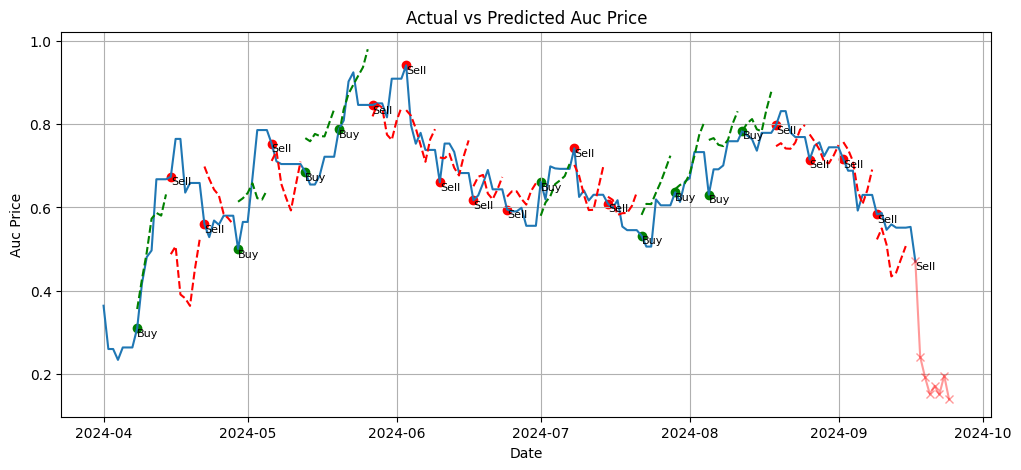

In [57]:
plot_model_results(multi_conv_model, test_df, INPUT_STEPS, OUT_STEPS)
